# Import Library

In [2]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Downloading Dataset

In [3]:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
url = 'https://drive.google.com/file/d/1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy/view?usp=sharing'
# Split link to get ID
split1 = url.split('d/')[1]
id = split1.split('/view?')[0]
print(id)

1aX4pxw4KsGbhz3ZP9STm0xfN4HyuN8cy


In [6]:
# Downloading file
file = drive.CreateFile({'id':id})
file.GetContentFile('Sidewalk_Object_Dataset.zip')

In [7]:
fzip = 'Sidewalk_Object_Dataset.zip'
zip_ref = zipfile.ZipFile(fzip, 'r')
zip_ref.extractall('./SidewalkDataset')
zip_ref.close()

# Image Augmentation

In [8]:
train_dir = '/content/SidewalkDataset/train'
val_dir = '/content/SidewalkDataset/val'

In [9]:
def train_val_generators(training_dir, validation_dir):
  train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      directory=train_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(150, 150)
  )
  
  val_datagen = ImageDataGenerator(rescale=1/255)

  val_generator = val_datagen.flow_from_directory(
      directory=val_dir,
      batch_size=32,
      class_mode='categorical',
      target_size=(150, 150)
  )

  return train_generator, val_generator

In [10]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 2254 images belonging to 9 classes.
Found 466 images belonging to 9 classes.


In [11]:
train_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [12]:
validation_generator.class_indices

{'Bench': 0,
 'Bicycle': 1,
 'Car': 2,
 'Flowerpot': 3,
 'Motorcycle': 4,
 'Person': 5,
 'Pole': 6,
 'Potholes': 7,
 'Truck': 8}

In [13]:
class_names = []
for category in train_generator.class_indices:
  class_names.append(category)

# Building Model Architecture

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [15]:
model.compile(
    optimizer='RMSprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/20
 3/71 [>.............................] - ETA: 37s - loss: 3.5096 - accuracy: 0.1154

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


71/71 [==============================] - 89s 1s/step - loss: 2.2497 - accuracy: 0.1158 - val_loss: 2.1947 - val_accuracy: 0.1717
Epoch 2/20
71/71 [==============================] - 72s 1s/step - loss: 2.1812 - accuracy: 0.1854 - val_loss: 1.9338 - val_accuracy: 0.2639
Epoch 3/20
71/71 [==============================] - 71s 1s/step - loss: 1.9564 - accuracy: 0.2493 - val_loss: 1.8479 - val_accuracy: 0.2747
Epoch 4/20
71/71 [==============================] - 71s 1s/step - loss: 1.8462 - accuracy: 0.2893 - val_loss: 1.6649 - val_accuracy: 0.4077
Epoch 5/20
71/71 [==============================] - 71s 1s/step - loss: 1.6964 - accuracy: 0.3580 - val_loss: 1.4633 - val_accuracy: 0.5043
Epoch 6/20
71/71 [==============================] - 72s 999ms/step - loss: 1.5664 - accuracy: 0.4224 - val_loss: 1.4042 - val_accuracy: 0.5000
Epoch 7/20
71/71 [==============================] - 71s 1s/step - loss: 1.5060 - accuracy: 0.4618 - val_loss: 1.2827 - val_accuracy: 0.5300
Epoch 8/20
71/71 [==========

# Plotting Accuracy and Loss

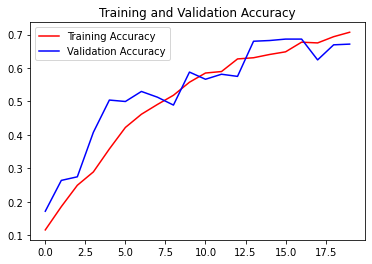

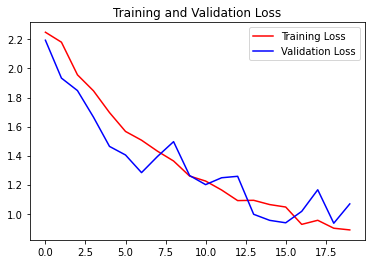

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Export Model

In [18]:
# Save model to h5 format
model.save('sidewalk_obj_v1.h5')

In [19]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir=export_dir)


INFO:tensorflow:Assets written to: saved_model/1/assets


In [20]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = "sidewalk_obj_v1.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('sidewalk_obj_v1.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [21]:
from google.colab import files
try:
    files.download('sidewalk_obj_v1.tflite')
    files.download('sidewalk_obj_v1.h5')
    files.download('sidewalk_obj_v1.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>